Sources  
- http://host.robots.ox.ac.uk/pascal/VOC/voc2007/ (pascal dataset)
- https://github.com/keshik6/pascal-voc-classification/tree/master (pascal github inspo)
- http://host.robots.ox.ac.uk/pascal/VOC/voc2007/devkit_doc_07-Jun-2007.pdf (pascal devkit)
- https://github.com/FabrizioDeSantis/Object-Detection-Manga109/tree/main (manga109 github inspo)
- manga109 dataset \
- manga109 libraries, api 
- manga109 paper 
- https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc 

Dependencies 

In [1]:
import manga109api_custom
from sklearn.model_selection import train_test_split
from dataset import CustomDataset
from torch.utils.data import DataLoader
import albumentations as A 
import pandas as pd
from albumentations.pytorch import ToTensorV2
import numpy as np
from matplotlib import pyplot as plt
from dataset import collate_fn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from train import train_model
import torch
from utils import Averager
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

Load Data (path access can be improved)

In [2]:
# directory with Manga109 data 
manga109_root_dir = "./Manga109/Manga109_released_2023_12_07" # directory with Manga109 data

# custom parser to access Manga109 data 
p = manga109api_custom.Parser(root_dir=manga109_root_dir)
img_dict = p.load_all_images()

# create pandas dataframe from the dictionary
df = pd.DataFrame(img_dict)
print(df)

                                                img_path  width  height  \
0      C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
1      C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
2      C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
3      C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
4      C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
...                                                  ...    ...     ...   
10125  C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
10126  C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
10127  C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
10128  C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   
10129  C:\Users\Grace\Documents\Manga109-BoundingDete...   1654    1170   

              book_id                                             bboxes  \
0                ARMS  

Split and Stratify Data 

In [3]:
test_ratio = 0.2
val_ratio = 0.2

# split data into training/validation and testing sets
train_val_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['book_id'], random_state=42)

# further split into training and validation sets 
train_df, val_df = train_test_split(train_val_df, test_size=val_ratio, stratify=train_val_df['book_id'], random_state=42)

print(f"Total Images: {len(df)}")
print(f"Training Images: {len(train_df)}")
print(f"Validation Images: {len(val_df)}")
print(f"Testing Images: {len(test_df)}")

Total Images: 10130
Training Images: 6483
Validation Images: 1621
Testing Images: 2026


Transforms (more can be added later)

In [7]:
# define training transform
train_transform = A.Compose([ 
    A.CenterCrop(height=1170, width=1650, p=1),                                 # crop first                         
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    #A.ColorJitter(brightness=(0.80, 1.20)),
    #A.Rotate(limit=90,p=0.5),                 
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(height=780, width=1100, interpolation=1, p=1),                     # resize last 
    ToTensorV2(), # change image to tensor 
    #ToTensor()   # change bboxes and labels to tensors 
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels'])) 

# define validation transform
val_transform = A.Compose([
    A.CenterCrop(height=1170, width=1650, p=1),
    A.Resize(height=780, width=1100, interpolation=1, p=1),
    #ToTensor(max_value=500)
])

Create Datasets & DataLoaders 

In [8]:
# datasets
train_dataset = CustomDataset(img_df=train_df, padding=100, transform=train_transform)
val_dataset = CustomDataset(img_df=val_df, transform=val_transform)

# dataloaders 
batch_size = 8
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn, shuffle=False)

Visualize Data - testing & validation images  

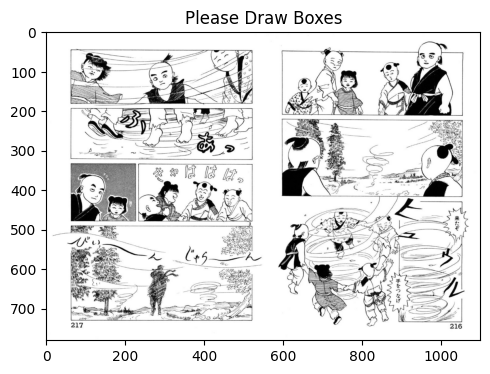

In [9]:
image, target = next(iter(train_loader))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(np.transpose(np.asarray(image[0]), (1, 2, 0)))
ax.set_title('Please Draw Boxes')
plt.show()

Model

In [12]:
# load Faster RCNN pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# get the number of input features 
in_features = model.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=4+1)

Training 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]  # get the model parameters

# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
train_loss_hist = Averager()
valid_loss_hist = Averager()

train_model(device, model, optimizer, train_loader, train_loss_hist, valid_loader, valid_loss_hist, num_epochs=num_epochs)


EPOCH 1 of 10
Training



Loss: 4.6052:   0%|          | 0/811 [01:10<?, ?it/s]

- Validation Metrics 
- Testing Images Visualization 
- Testing 
- Testing Evaluation Metrics 